<a name="Load"></a>
## Load Data 

Download the images from a GCP bucket (this only needs to run if running on colab or first run on local):

In [1]:
import pandas as pd
import requests
import io
import urllib.parse

import numpy as np

from PIL import Image



import os

import random

import datetime as dt

import matplotlib.pyplot as plt

In [3]:
import tqdm

In [4]:
import torch
# from skimage import io
from torch.utils.data import Dataset



from torch.cuda.amp import GradScaler, autocast

import torchvision
from torchvision import models, transforms

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F

In [5]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './data/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


Read in the train, test, and sample submission CSV files as pandas dataframes:

In [6]:
BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

In [7]:
# Read in csv files.
train_path = os.path.join(os.path.dirname(IMAGE_DIR), 'train.csv')
if os.path.exists(train_path):
    train = pd.read_csv(train_path)
else:
    train = read_csv_from_web('train.csv')
    train.to_csv(train_path, index=False)
    
test_path = os.path.join(os.path.dirname(IMAGE_DIR), 'test.csv')
if os.path.exists(test_path):
    test = pd.read_csv(test_path)
else:
    test = read_csv_from_web('test.csv')
    test.to_csv(test_path, index=False)
  

    
extra_path = os.path.join(os.path.dirname(IMAGE_DIR), 'extra_images.csv')
if os.path.exists(extra_path):
    extra = pd.read_csv(extra_path)
else:
    extra = read_csv_from_web('extra_images.csv')
    extra.to_csv(extra_path, index=False)
   
# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

Quickly check the data

In [8]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [9]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [10]:
extra.head()

,image_id,turtle_id
0,ID_Y0KYE5XD,t_id_he7JTQxO
1,ID_8JTIQ4UI,t_id_he7JTQxO
2,ID_LSXPZYSN,t_id_he7JTQxO
3,ID_SHZ2HDSP,t_id_he7JTQxO
4,ID_6TOFB06E,t_id_xry0Yg2j


## Datasets and Dataloaders

### Dataset for Triplet Loss

In [11]:
# Dataset to generate triplets (anchor, positive, negative) for training
class TripletDataset(Dataset):

    def __init__(self, root_dir, labels_df, num_triplets, easy_mode=False, transform=None):

        self.root_dir = root_dir
        self.df = labels_df
        self.num_triplets = num_triplets
        self.transform = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_triplets, easy_mode)
        self.easy_mode = easy_mode


    @staticmethod
    def generate_triplets(df, num_triplets, easy_mode):

        def make_dictionary_for_turtle_classes(df, easy_mode):
            orientations = df['image_location'].unique().tolist()
            turtle_classes = {}
            if easy_mode:
              for turtle_id in train['turtle_id'].unique():
                for orientation in orientations:
                  turtle_image_ids = train[(train['turtle_id']==turtle_id) & (train['image_location']==orientation)]['image_id'].tolist()
                  turtle_classes[turtle_id]=turtle_image_ids
            else:
              for turtle_id in train['turtle_id'].unique():
                turtle_image_ids = train[train['turtle_id']==turtle_id]['image_id'].tolist()
                turtle_classes[turtle_id]=turtle_image_ids
            return turtle_classes

        triplets = []
        classes = df['turtle_id'].unique()
        turtle_classes = make_dictionary_for_turtle_classes(df, easy_mode)

        for _ in range(num_triplets):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''

            pos_class = np.random.choice(classes)
            neg_class = np.random.choice(classes)
            while len(turtle_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)
            while pos_class == neg_class:
                neg_class = np.random.choice(classes)


            if len(turtle_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size=2, replace=False)
            else:
                ianc = np.random.randint(0, len(turtle_classes[pos_class]))
                ipos = np.random.randint(0, len(turtle_classes[pos_class]))
                while ianc == ipos:
                    ipos = np.random.randint(0, len(turtle_classes[pos_class]))
            ineg = np.random.randint(0, len(turtle_classes[neg_class]))

            anc_id = turtle_classes[pos_class][ianc]
            pos_id = turtle_classes[pos_class][ipos]
            neg_id = turtle_classes[neg_class][ineg]

            triplets.append(
                [anc_id, pos_id, neg_id, pos_class, neg_class])

        return triplets

    def __getitem__(self, idx):
        anc_id, pos_id, neg_id, pos_class, neg_class = self.training_triplets[idx]

        anc_img = os.path.join(self.root_dir, anc_id +'.JPG')
        pos_img = os.path.join(self.root_dir, pos_id +'.JPG')
        neg_img = os.path.join(self.root_dir, neg_id +'.JPG')

        anc_img = Image.open(anc_img)
        pos_img = Image.open(pos_img)
        neg_img = Image.open(neg_img)

        # pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))
        # neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))

        sample = {'anc_img': anc_img, 'pos_img': pos_img, 'neg_img': neg_img, 'pos_class': pos_class,
                  'neg_class': neg_class}

        if self.transform:
            sample['anc_img'] = self.transform(sample['anc_img'])
            sample['pos_img'] = self.transform(sample['pos_img'])
            sample['neg_img'] = self.transform(sample['neg_img'])

        return sample

    def __len__(self):
        return len(self.training_triplets)

### Dataset for Embedding Training

In [12]:
# Dataset to generate samples for embedding loss (img1, img2, +/-1)
class EmbeddingDataset(Dataset):

    def __init__(self, root_dir, labels_df, num_samples, easy_mode=False, transform=None):

        self.root_dir = root_dir
        self.df = labels_df
        self.num_samples = num_samples
        self.transform = transform
        self.training_samples = self.generate_samples(self.df, self.num_triplets, easy_mode)
        self.easy_mode = easy_mode


    @staticmethod
    def generate_samples(df, num_samples, easy_mode):

        def make_dictionary_for_turtle_classes(df, classes, easy_mode):
            orientations = df['image_location'].unique().tolist()
            
            turtle_classes = {}
            
            if easy_mode:
                
                for turtle_id in classes:
                    for orientation in orientations:
                        turtle_image_ids = df[(df['turtle_id']==turtle_id) & (df['image_location']==orientation)]['image_id'].tolist()
                  
            else:
                for turtle_id in classes:
                    turtle_image_ids = df[df['turtle_id']==df]['image_id'].tolist()
                    turtle_classes[turtle_id]=turtle_image_ids
            
            return turtle_classes

        samples = []
        classes = df['turtle_id'].unique()
        turtle_classes = make_dictionary_for_turtle_classes(df, classes,easy_mode)

        for _ in range(num_samples):

            
            # Randomly select whether to generate positive or negative sample
            is_positive_sample = random.choice([True, False])
            
            if is_positive_sample:
                    pos_class = np.random.choice(classes)
                    
                    if easy_mode:
                        orientation = df['image_location'].sample().values[0]
                        while len(turtle_classes[pos_class][orientation]) < 2:
                            pos_class = np.random.choice(classes)
                            orientation = df['image_location'].sample().values[0]
                        pos_imgs = turtle_classes[pos_class][orientation]
                    else:
                        while len(turtle_classes[pos_class]) < 2:
                            pos_class = np.random.choice(classes)
                        pos_imgs = turtle_classes[pos_class]
                    
                    img1, img2 = np.random.choice(pos_imgs, size=2, replace=False)
                    
                    sample = (img1, img2, 1)
                    
            else:
                    pos_class = np.random.choice(classes)
                    neg_class = np.random.choice(classes)
                    # Resample if positive and negative classes are same
                    while pos_class == neg_class:
                        neg_class = np.random.choice(classes)
                    if easy_mode:
                        orientation = df['image_location'].sample().values[0]
                        pos_imgs = turtle_classes[pos_class][orientation]
                        # Resample if negative class has no images with same orientation
                        while len(turtle_classes[neg_class][orientation])==0:
                            neg_class = np.random.choice(classes)
                        
                        neg_imgs = turtle_classes[neg_class][orientation]
                    else:
                        pos_imgs = turtle_classes[pos_class]
                        neg_imgs = turtle_classes[neg_class]
                            
                    img1 = np.random.choice(pos_imgs)
                    img2 = np.random.choice(neg_imgs)
                    
                    sample = (img1, img2, -1)
                    
            samples.append(samples)

        return samples

    def __getitem__(self, idx):
        img1_id, img2_id, y = self.samples[idx]

        img1_path = os.path.join(self.root_dir, img1_id +'.JPG')
        img2_path = os.path.join(self.root_dir, img2_id +'.JPG')

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)


        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, y

    def __len__(self):
        return self.num_samples

### Simple Dataset 
Treats the problem as a simple classification problem

In [13]:
# Dataset to generate triplets (anchor, positive, negative) for training
class TurtleDataSet(Dataset):
    """
    Args:
        root_dir (string): Root directory of dataset  images
        labels_df (Dataframe): 
        label_ids (list): list of ids in training set
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        include_orientation (boolean, optional): whether to include orientation as well
    """
    def __init__(self, root_dir, labels_df, label_ids, transform=None, include_orientation=True):

        self.root_dir = root_dir
        self.include_orientation = include_orientation
        if self.include_orientation:
            # self.df = pd.concat([labels_df['image_id'], 
            #                      pd.get_dummies(labels_df['image_location']), 
            #                      pd.get_dummies(labels_df['turtle_id'])], 
            #                     axis=1)
            self.df = labels_df
        else:
            self.df = labels_df[['image_id', 'turtle_id']]
        # self.df = pd.concat([labels_df['image_id'], pd.get_dummies(labels_df['image_location']), labels_df['turtle_id']], axis=1)
        self.turtle_ids = label_ids
        self.transform = transform
        self.orientation_map = {'left': 0,
                                'right': 1,
                                'top': 2}

    def __getitem__(self, idx):

        # id_labels = self.df.loc[idx, self.df.columns.str.startswith('t_id')].values.argmax()
        # id_labels = self.df.loc[idx, self.df.columns.str.startswith('t_id')].values
        
        
        turtle_id = self.df.loc[idx, 'turtle_id']
        try:
            id_label = turtle_ids.index(turtle_id)
        except ValueError:
            id_label = len(self.turtle_ids)
        
        image_id = self.df.loc[idx, 'image_id']
        img_path = os.path.join(self.root_dir, image_id +'.JPG')
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
            
        
        if self.include_orientation:
            try:
                orientation_label = self.orientation_map[self.df.loc[idx, 'image_location']]
            except:
                orientation_label = random.choice([0,1,2])

            return {'img':img,
                    'image_id':image_id,
                    'orientation':orientation_label}
        else:
            
            return {'img':img, 
                    'image_id':image_id,
                    'id':id_label}

    def __len__(self):
        return len(self.df)

Add some unknown turtles to the training set

In [14]:
turtle_ids = train.turtle_id.unique().tolist()

In [15]:
unknown_ids = set(extra.turtle_id.unique()) - set(train.turtle_id.unique())

unknown_train_ids = random.sample(list(unknown_ids), 100)

train_df = [train]
for unknown_train_id in unknown_train_ids:
    train_df.append(extra[extra.turtle_id==unknown_train_id])

train_df = pd.concat(train_df).reset_index()

In [16]:
len(train)

2145

In [17]:
len(unknown_ids)

2165

In [18]:
print("%d images of unkown turtles added"%train_df.image_location.isna().sum())

504 images of unkown turtles added


In [19]:
train_df.loc[train_df.image_location.isna(), 'turtle_id'] = 'new_turtle'

In [20]:
train_df = train_df.drop('index', axis=1)

In [21]:
turtle_weights = (train_df.groupby('turtle_id')['image_id'].count()/train_df.shape[0]).reset_index().sort_values('turtle_id', ascending=False).reset_index(drop=True)

In [22]:
turtle_ids = turtle_weights['turtle_id'].tolist()[:-1]

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Image Transforms

In [24]:
# A custom transform to pad all images in a batch to same size,  taken from https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/5
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

## Competition Metrics

In [25]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [26]:
def get_id_from_idx(idx, ids=turtle_ids):
    try:
        return ids[idx]
    except IndexError:
        return "new_turtle"

mapper = np.vectorize(get_id_from_idx)

## As Classification

### EfficientNet

In [182]:
model_conv = torchvision.models.efficientnet_b2(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /home/xion/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


In [205]:
# Freeze all weights
for param in model_conv.parameters():
    param.requires_grad = False

# Add a new layer on top
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True), nn.Linear(num_ftrs,len(turtle_ids)+1), nn.ReLU())
# model_conv.classifier[6] = nn.Linear(num_ftrs,100)

# Unfreeze the weights of the classifier
model_conv.requires_grad_(True)

# AS well as the last feature layers
model_conv.features[-1].requires_grad_(True)

ConvNormActivation(
  (0): Conv2d(352, 1408, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1408, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

In [206]:
img_transform = transforms.Compose([
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [207]:
dataset = TurtleDataSet(IMAGE_DIR, train_df, turtle_ids, transform=img_transform, include_orientation=False)

In [208]:
batch_size = 128

In [209]:
num_epoch_steps = int(np.ceil(len(dataset)/batch_size))

In [210]:
num_epoch_steps

21

In [211]:
# cross_entropy = nn.CrossEntropyLoss(weight=torch.tensor(turtle_weights['image_id'].values, dtype=torch.float).to(device))
cross_entropy = nn.CrossEntropyLoss()

In [212]:
model_conv.to(device)
model_conv.train();

In [213]:
top_k_precisions = []
epoch_losses = []

In [214]:
torch.cuda.empty_cache()

In [215]:
optimizer_model = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()),
                             lr=0.001, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_model,
                                                   max_lr=0.0001,
                                                   anneal_strategy='linear',
                                                   epochs=50,
                                                   steps_per_epoch=num_epoch_steps
                                                   # three_phase=True
                                                  )

In [216]:
for epoch in range(25):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        optimizer_model.zero_grad() 
        with autocast():
            op = model_conv(sample['img'].to(device))
            loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * sample['img'].size(0)
        top_k_precision = mapk(sample['id'], op.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pbar.set_description('Epoch %d - MAP@k : %f - Learning Rate : %f' % (epoch+1, top_k_precision, lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - MAP@k : %f - Loss %f' % (epoch+1, np.mean(top_k_precisions[-num_epoch_steps:]), epoch_loss))

Epoch 1 - MAP@k : 0.023783 - Learning Rate : 0.000010: 100%|████████████████████████████████████████████████████████| 21/21 [02:20<00:00,  6.71s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 1 - MAP@k : 0.031093 - Loss 4.605620


Epoch 2 - MAP@k : 0.105618 - Learning Rate : 0.000017: 100%|████████████████████████████████████████████████████████| 21/21 [01:53<00:00,  5.39s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 2 - MAP@k : 0.073767 - Loss 4.536718


Epoch 3 - MAP@k : 0.248689 - Learning Rate : 0.000023: 100%|████████████████████████████████████████████████████████| 21/21 [01:57<00:00,  5.57s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 3 - MAP@k : 0.193409 - Loss 4.374535


Epoch 4 - MAP@k : 0.366479 - Learning Rate : 0.000030: 100%|████████████████████████████████████████████████████████| 21/21 [01:54<00:00,  5.47s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 4 - MAP@k : 0.286865 - Loss 4.145791


Epoch 5 - MAP@k : 0.408989 - Learning Rate : 0.000036: 100%|████████████████████████████████████████████████████████| 21/21 [01:58<00:00,  5.64s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 5 - MAP@k : 0.384295 - Loss 3.817629


Epoch 6 - MAP@k : 0.488951 - Learning Rate : 0.000043: 100%|████████████████████████████████████████████████████████| 21/21 [01:59<00:00,  5.70s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 6 - MAP@k : 0.496039 - Loss 3.441750


Epoch 7 - MAP@k : 0.602247 - Learning Rate : 0.000049: 100%|████████████████████████████████████████████████████████| 21/21 [01:58<00:00,  5.63s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 7 - MAP@k : 0.598929 - Loss 3.088528


Epoch 8 - MAP@k : 0.672285 - Learning Rate : 0.000055: 100%|████████████████████████████████████████████████████████| 21/21 [02:01<00:00,  5.80s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 8 - MAP@k : 0.680265 - Loss 2.736912


Epoch 9 - MAP@k : 0.756367 - Learning Rate : 0.000062: 100%|████████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.86s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 9 - MAP@k : 0.755834 - Loss 2.373123


Epoch 10 - MAP@k : 0.711049 - Learning Rate : 0.000068: 100%|███████████████████████████████████████████████████████| 21/21 [02:05<00:00,  5.98s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 10 - MAP@k : 0.807774 - Loss 2.049667


Epoch 11 - MAP@k : 0.859925 - Learning Rate : 0.000075: 100%|███████████████████████████████████████████████████████| 21/21 [01:59<00:00,  5.69s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 11 - MAP@k : 0.842896 - Loss 1.753963


Epoch 12 - MAP@k : 0.953184 - Learning Rate : 0.000081: 100%|███████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.86s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 12 - MAP@k : 0.865795 - Loss 1.494583


Epoch 13 - MAP@k : 0.919476 - Learning Rate : 0.000087: 100%|███████████████████████████████████████████████████████| 21/21 [02:02<00:00,  5.83s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 13 - MAP@k : 0.894498 - Loss 1.275036


Epoch 14 - MAP@k : 0.919476 - Learning Rate : 0.000094: 100%|███████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.87s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 14 - MAP@k : 0.922151 - Loss 1.064271


Epoch 15 - MAP@k : 0.902622 - Learning Rate : 0.000100: 100%|███████████████████████████████████████████████████████| 21/21 [01:59<00:00,  5.71s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 15 - MAP@k : 0.939293 - Loss 0.888197


Epoch 16 - MAP@k : 0.958801 - Learning Rate : 0.000097: 100%|███████████████████████████████████████████████████████| 21/21 [02:04<00:00,  5.93s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 16 - MAP@k : 0.953637 - Loss 0.745621


Epoch 17 - MAP@k : 0.950375 - Learning Rate : 0.000094: 100%|███████████████████████████████████████████████████████| 21/21 [02:08<00:00,  6.10s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 17 - MAP@k : 0.963497 - Loss 0.601906


Epoch 18 - MAP@k : 0.971910 - Learning Rate : 0.000091: 100%|███████████████████████████████████████████████████████| 21/21 [02:08<00:00,  6.11s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 18 - MAP@k : 0.971976 - Loss 0.504163


Epoch 19 - MAP@k : 0.994382 - Learning Rate : 0.000088: 100%|███████████████████████████████████████████████████████| 21/21 [02:01<00:00,  5.80s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 19 - MAP@k : 0.981032 - Loss 0.423900


Epoch 20 - MAP@k : 0.986891 - Learning Rate : 0.000086: 100%|███████████████████████████████████████████████████████| 21/21 [02:06<00:00,  6.02s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 20 - MAP@k : 0.988215 - Loss 0.360728


Epoch 21 - MAP@k : 0.988764 - Learning Rate : 0.000083: 100%|███████████████████████████████████████████████████████| 21/21 [02:08<00:00,  6.11s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 21 - MAP@k : 0.990474 - Loss 0.301985


Epoch 22 - MAP@k : 0.988764 - Learning Rate : 0.000080: 100%|███████████████████████████████████████████████████████| 21/21 [02:04<00:00,  5.95s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 22 - MAP@k : 0.989898 - Loss 0.266454


Epoch 23 - MAP@k : 1.000000 - Learning Rate : 0.000077: 100%|███████████████████████████████████████████████████████| 21/21 [02:34<00:00,  7.37s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 23 - MAP@k : 0.993744 - Loss 0.228887


Epoch 24 - MAP@k : 0.991573 - Learning Rate : 0.000074: 100%|███████████████████████████████████████████████████████| 21/21 [02:12<00:00,  6.29s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 24 - MAP@k : 0.993398 - Loss 0.213041


Epoch 25 - MAP@k : 1.000000 - Learning Rate : 0.000071: 100%|███████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.90s/it]

Epoch 25 - MAP@k : 0.996032 - Loss 0.178607


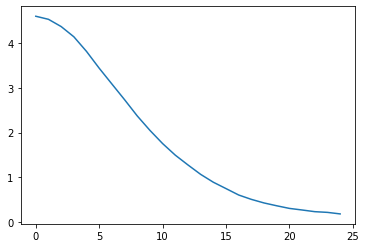

In [218]:
plt.plot(epoch_losses)

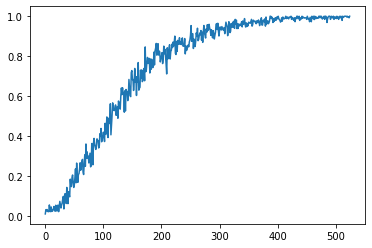

In [219]:
plt.plot(top_k_precisions)

In [199]:
for epoch in range(25):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        optimizer_model.zero_grad() 
        with autocast():
            op = model_conv(sample['img'].to(device))
            loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * sample['img'].size(0)
        top_k_precision = mapk(sample['id'], op.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pbar.set_description('Epoch %d - MAP@k : %f - Learning Rate : %f' % (epoch+1, top_k_precision, lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - MAP@k : %f - Loss %f' % (epoch+1, np.mean(top_k_precisions[-num_epoch_steps:]), epoch_loss))

Epoch 1 - MAP@k : 0.916105 - Learning Rate : 0.000068: 100%|████████████████████████████████████████████████████████| 21/21 [01:53<00:00,  5.39s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 1 - MAP@k : 0.915065 - Loss 0.942729


Epoch 2 - MAP@k : 0.944757 - Learning Rate : 0.000066: 100%|████████████████████████████████████████████████████████| 21/21 [01:53<00:00,  5.42s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 2 - MAP@k : 0.929432 - Loss 0.867848


Epoch 3 - MAP@k : 0.944195 - Learning Rate : 0.000063: 100%|████████████████████████████████████████████████████████| 21/21 [01:52<00:00,  5.35s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 3 - MAP@k : 0.937881 - Loss 0.772991


Epoch 4 - MAP@k : 0.944757 - Learning Rate : 0.000060: 100%|████████████████████████████████████████████████████████| 21/21 [01:54<00:00,  5.46s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 4 - MAP@k : 0.943779 - Loss 0.703741


Epoch 5 - MAP@k : 0.940075 - Learning Rate : 0.000057: 100%|████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.54s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 5 - MAP@k : 0.954035 - Loss 0.640757


Epoch 6 - MAP@k : 0.988764 - Learning Rate : 0.000054: 100%|████████████████████████████████████████████████████████| 21/21 [01:54<00:00,  5.45s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 6 - MAP@k : 0.957507 - Loss 0.600407


Epoch 7 - MAP@k : 0.958801 - Learning Rate : 0.000051: 100%|████████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.55s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 7 - MAP@k : 0.968258 - Loss 0.516966


Epoch 8 - MAP@k : 0.981273 - Learning Rate : 0.000048: 100%|████████████████████████████████████████████████████████| 21/21 [01:52<00:00,  5.38s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 8 - MAP@k : 0.968702 - Loss 0.497706


Epoch 9 - MAP@k : 0.923221 - Learning Rate : 0.000046: 100%|████████████████████████████████████████████████████████| 21/21 [01:59<00:00,  5.70s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 9 - MAP@k : 0.969552 - Loss 0.460454


Epoch 10 - MAP@k : 0.983146 - Learning Rate : 0.000043: 100%|███████████████████████████████████████████████████████| 21/21 [01:52<00:00,  5.37s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 10 - MAP@k : 0.975177 - Loss 0.426574


Epoch 11 - MAP@k : 0.955056 - Learning Rate : 0.000040: 100%|███████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.56s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 11 - MAP@k : 0.975731 - Loss 0.391641


Epoch 12 - MAP@k : 0.955993 - Learning Rate : 0.000037: 100%|███████████████████████████████████████████████████████| 21/21 [01:53<00:00,  5.38s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 12 - MAP@k : 0.975236 - Loss 0.383967


Epoch 13 - MAP@k : 0.988764 - Learning Rate : 0.000034: 100%|███████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.55s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 13 - MAP@k : 0.980176 - Loss 0.356433


Epoch 14 - MAP@k : 0.971910 - Learning Rate : 0.000031: 100%|███████████████████████████████████████████████████████| 21/21 [01:56<00:00,  5.54s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 14 - MAP@k : 0.981140 - Loss 0.332896


Epoch 15 - MAP@k : 0.988764 - Learning Rate : 0.000028: 100%|███████████████████████████████████████████████████████| 21/21 [02:56<00:00,  8.39s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 15 - MAP@k : 0.981279 - Loss 0.324188


Epoch 16 - MAP@k : 0.960674 - Learning Rate : 0.000026: 100%|███████████████████████████████████████████████████████| 21/21 [02:56<00:00,  8.40s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 16 - MAP@k : 0.983866 - Loss 0.303510


Epoch 17 - MAP@k : 0.971910 - Learning Rate : 0.000023: 100%|███████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.90s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 17 - MAP@k : 0.984383 - Loss 0.292488


Epoch 18 - MAP@k : 0.953184 - Learning Rate : 0.000020: 100%|███████████████████████████████████████████████████████| 21/21 [01:57<00:00,  5.62s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 18 - MAP@k : 0.983305 - Loss 0.284562


Epoch 19 - MAP@k : 1.000000 - Learning Rate : 0.000017: 100%|███████████████████████████████████████████████████████| 21/21 [01:54<00:00,  5.44s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 19 - MAP@k : 0.987853 - Loss 0.283152


Epoch 20 - MAP@k : 0.992509 - Learning Rate : 0.000014: 100%|███████████████████████████████████████████████████████| 21/21 [02:00<00:00,  5.73s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 20 - MAP@k : 0.988080 - Loss 0.259183


Epoch 21 - MAP@k : 0.981273 - Learning Rate : 0.000011: 100%|███████████████████████████████████████████████████████| 21/21 [02:02<00:00,  5.84s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 21 - MAP@k : 0.986490 - Loss 0.261954


Epoch 22 - MAP@k : 0.977528 - Learning Rate : 0.000008: 100%|███████████████████████████████████████████████████████| 21/21 [02:07<00:00,  6.08s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 22 - MAP@k : 0.988141 - Loss 0.257882


Epoch 23 - MAP@k : 0.994382 - Learning Rate : 0.000006: 100%|███████████████████████████████████████████████████████| 21/21 [02:10<00:00,  6.23s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 23 - MAP@k : 0.986631 - Loss 0.254364


Epoch 24 - MAP@k : 0.977528 - Learning Rate : 0.000003: 100%|███████████████████████████████████████████████████████| 21/21 [02:06<00:00,  6.03s/it]
  0%|                                                                                                                        | 0/21 [00:00<?, ?it/s]

Epoch 24 - MAP@k : 0.986653 - Loss 0.254643


Epoch 25 - MAP@k : 0.988764 - Learning Rate : -0.000000: 100%|██████████████████████████████████████████████████████| 21/21 [01:57<00:00,  5.59s/it]

Epoch 25 - MAP@k : 0.988738 - Loss 0.233942


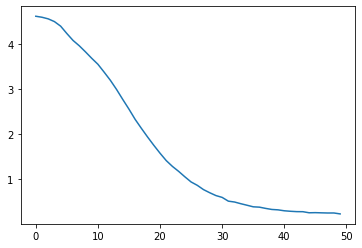

In [200]:
plt.plot(epoch_losses)

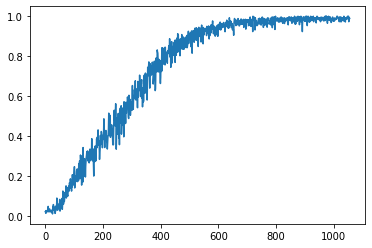

In [201]:
plt.plot(top_k_precisions)

### Validation on extra images

In [202]:
extra.shape

(10658, 2)

In [203]:
extra[~extra.turtle_id.isin(unknown_train_ids)].shape

(10154, 2)

In [220]:
extra_dataset = TurtleDataSet(IMAGE_DIR, extra[~extra.turtle_id.isin(unknown_train_ids)].reset_index(),
                              turtle_ids, 
                              transform=img_transform, 
                              include_orientation=False)

In [221]:
model_conv.eval();

In [222]:
data_loader = torch.utils.data.DataLoader(extra_dataset, batch_size=128, shuffle=False, num_workers=1)
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
preds = []
image_ids = []
val_precisions = []
with torch.no_grad():
    for sample in pbar:
        out = model_conv(sample['img'].to(device))
        # break
        top_k_precision = mapk(sample['id'], out.topk(5, dim=1).indices)
        val_precisions.append(top_k_precision)
        pred = out.topk(5, dim=1).indices.cpu().numpy()
        preds.append(pred)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [13:32<00:00, 10.16s/it]


In [223]:
np.mean(val_precisions)

0.6856975446428573

In [224]:
reserved_mem = torch.cuda.memory_reserved(0)
allocated_mem = torch.cuda.memory_allocated(0)

mem_use = allocated_mem/reserved_mem

In [225]:
mem_use

0.08453042223251431

### Generate Predictions for Submission

In [226]:
test['turtle_id'] = ''

In [227]:
model_conv.eval();

In [228]:
test_dataset = TurtleDataSet(IMAGE_DIR, test, turtle_ids, transform=img_transform, include_orientation=False)

In [229]:
len(test_dataset)

490

In [230]:
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=490, shuffle=False, num_workers=1)

# data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

preds = []
image_ids = []
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
with torch.no_grad():
    for sample in pbar:
        image_ids.extend(sample['image_id'])
        test_emb = model_conv(sample['img'].to(device))
        pred = test_emb.topk(5, dim=1).indices.cpu().numpy()
        preds.append(pred)
        # break


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.16s/it]


In [231]:
test_emb.shape

torch.Size([490, 101])

In [232]:
image_ids = list(map(lambda x:x.upper(), image_ids))

In [233]:
preds = np.concatenate(preds)

In [234]:
sum(preds==100)

array([53, 15, 12,  1,  8])

In [55]:
sum(preds==100)

array([65, 31, 29, 24, 12])

In [235]:
preds = mapper(preds)

predictions_df = pd.DataFrame({'image_id': image_ids,
                               'prediction1': preds[:, 0],
                               'prediction2': preds[:, 1],
                               'prediction3': preds[:, 2],
                               'prediction4': preds[:, 3],
                               'prediction5': preds[:, 4]})

In [236]:
predictions_df.to_csv(os.path.join('predictions', dt.datetime.now().strftime("%Y-%m-%d-%H-%M.csv")),
                      index=False)

In [328]:
len(image_ids)

490

## As Margin Maximization

### Dataset for Embedding Loss

In [237]:
# Dataset to generate triplets (anchor, positive, negative) for training
class EmbeddingDataset(Dataset):

    def __init__(self, root_dir, labels_df, num_samples, easy_mode=False, transform=None):

        self.root_dir = root_dir
        self.df = labels_df
        self.num_samples = num_samples
        self.samples = self.generate_samples(self.df, self.num_samples, easy_mode)
        self.easy_mode = easy_mode
        self.transform = transform


    @staticmethod
    def generate_samples(df, num_samples, easy_mode):

        def make_dictionary_for_turtle_classes(df, easy_mode):
            
            turtle_classes = {}
            if easy_mode:
                orientations = df['image_location'].unique().tolist()

                for turtle_id in df['turtle_id'].unique():
                    turtle_classes[turtle_id] = {}
                    for orientation in orientations:
                      turtle_image_ids = df[(df['turtle_id']==turtle_id) & (df['image_location']==orientation)]['image_id'].tolist()
                      turtle_classes[turtle_id][orientation]=turtle_image_ids
            else:
              for turtle_id in df['turtle_id'].unique():
                turtle_image_ids = df[df['turtle_id']==turtle_id]['image_id'].tolist()
                turtle_classes[turtle_id]=turtle_image_ids
            return turtle_classes

        samples = []
        classes = df['turtle_id'].unique()
        turtle_classes = make_dictionary_for_turtle_classes(df, easy_mode)

        for _ in range(num_samples):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''
            is_positive_sample = random.choice([True, False])
            
            # print(turtle_classes)
            if is_positive_sample:
                pos_class = turtle_classes[np.random.choice(classes)]
                if easy_mode:
                    # Randomly choose an orientation
                    orientations = list(pos_class.keys())
                    # We want to train on turtles which have at least been photographed from orientations
                    while len(orientations) < 2:
                        pos_class = turtle_classes[np.random.choice(classes)]
                        orientations = list(pos_class.keys())
                    
                    orientation = random.choice(orientations)
                    while len(pos_class[orientation])<2:
                        orientation = random.choice(orientations)
                    image_ids = np.random.choice(pos_class[orientation], 2, replace=False)
                else:
                    # print(pos_class)
                    while len(pos_class)<2:
                        pos_class = turtle_classes[np.random.choice(classes)]
                    image_ids = np.random.choice(pos_class, 2, replace=False)
                sample = (image_ids[0], image_ids[1], 1)
            else:
                pos_class = turtle_classes[np.random.choice(classes)]
                neg_class = turtle_classes[np.random.choice(classes)]
                
                if easy_mode:
                    # Randomly choose an orientation
                    orientation = random.choice(list(pos_class.keys()))
                    pos_id = np.random.choice(pos_class[orientation], 1, replace=False)
                    
                    # REsample a negative class if the same orientation is not available
                    while orientation not in neg_class.keys():
                        neg_class = np.random.choice(classes)
                        
                    neg_id = np.random.choice(neg_class[orientation], 1, replace=False)
                    
                else:
                    
                    pos_id = np.random.choice(pos_class, 1, replace=False)
                    neg_id = np.random.choice(neg_class, 1, replace=False)
                    
                sample = (pos_id[0], neg_id[0], -1)
            
            

            samples.append(sample)
                

        return samples

    def __getitem__(self, idx):
        id1, id2, y = self.samples[idx]

        img1 = os.path.join(self.root_dir, id1 +'.JPG')
        img2 = os.path.join(self.root_dir, id2 +'.JPG')

        img1 = Image.open(img1)
        img2 = Image.open(img2)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, y

    def __len__(self):
        return self.num_samples

In [238]:
# Since this model was pretrained above
# We want to freeze all weights
for param in model_conv.parameters():
    param.requires_grad = False

In [239]:
model_conv.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=101, bias=True)
  (2): ReLU()
)

In [313]:
# Add a few new layers to replace the old classifier
model_conv.classifier = nn.Sequential(nn.Linear(num_ftrs, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU())
# model_conv.classifier[6] = nn.Linear(num_ftrs,100)

In [314]:

for param in model_conv.classifier.parameters():
    param.requires_grad = True

### Cosine Embedding Loss

In [315]:
cosine_loss = nn.CosineEmbeddingLoss(margin=0.5)

In [316]:
model_conv.to(device)
model_conv.train();

In [317]:
num_training_samples = 4096
batch_size=128

In [246]:
scaler = GradScaler()

optimizer_model = optim.SGD(
    params=filter(lambda p: p.requires_grad, model_conv.parameters()),
    lr=0.0001,
    momentum=0.0,
    dampening=0,
    nesterov=False)

lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer_model, 
                                                 base_lr=0.00004,
                                                 max_lr=0.002, 
                                                 step_size_up=32, 
                                                 step_size_down=64)

In [247]:
scaler = GradScaler()

optimizer_model = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()),
                             lr=0.001, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_model,
                                                   max_lr=0.001,
                                                   anneal_strategy='linear',
                                                   epochs=20,
                                                   steps_per_epoch=int(num_training_samples/batch_size),
                                                   three_phase=True
                                                   
                                                  )

In [248]:
epoch_losses = []

#### Easy Training

In [249]:
for epoch in range(10):
    dataset = EmbeddingDataset(IMAGE_DIR, train, num_training_samples, transform=img_transform, easy_mode=True)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        img1, img2, y =  sample
        optimizer_model.zero_grad() 
        with autocast():
            op1 = model_conv(img1.to(device))
            op2 = model_conv(img2.to(device))
            loss = cosine_loss(op1, op2, y.to(device))
            # loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * img1.size(0)
        pbar.set_description('Epoch %d - Loss : %f - Learning Rate : %f' % (epoch+1, loss.item(), lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - Loss %f' % (epoch+1, epoch_loss))

Epoch 1 - Loss : 0.116615 - Learning Rate : 0.000201: 100%|███████████████████████████████████████████████████████████████| 32/32 [06:32<00:00, 12.26s/it]


Epoch 1 - Loss 0.137996


Epoch 2 - Loss : 0.088539 - Learning Rate : 0.000362: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:59<00:00, 11.22s/it]


Epoch 2 - Loss 0.093199


Epoch 3 - Loss : 0.068488 - Learning Rate : 0.000523: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:38<00:00, 10.59s/it]


Epoch 3 - Loss 0.071473


Epoch 4 - Loss : 0.053587 - Learning Rate : 0.000683: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:53<00:00, 11.05s/it]


Epoch 4 - Loss 0.061199


Epoch 5 - Loss : 0.052847 - Learning Rate : 0.000844: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:51<00:00, 10.99s/it]


Epoch 5 - Loss 0.050993


Epoch 6 - Loss : 0.047547 - Learning Rate : 0.000995: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:56<00:00, 11.13s/it]


Epoch 6 - Loss 0.045662


Epoch 7 - Loss : 0.032374 - Learning Rate : 0.000834: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:51<00:00, 11.00s/it]


Epoch 7 - Loss 0.037748


Epoch 8 - Loss : 0.028742 - Learning Rate : 0.000673: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:55<00:00, 11.12s/it]


Epoch 8 - Loss 0.035424


Epoch 9 - Loss : 0.038982 - Learning Rate : 0.000512: 100%|███████████████████████████████████████████████████████████████| 32/32 [05:42<00:00, 10.70s/it]


Epoch 9 - Loss 0.035489


Epoch 10 - Loss : 0.025564 - Learning Rate : 0.000352: 100%|██████████████████████████████████████████████████████████████| 32/32 [05:50<00:00, 10.96s/it]

Epoch 10 - Loss 0.029037


In [128]:
np.mean(epoch_losses)

0.15380670360755175

In [250]:
np.mean(epoch_losses)

0.059822056005941704

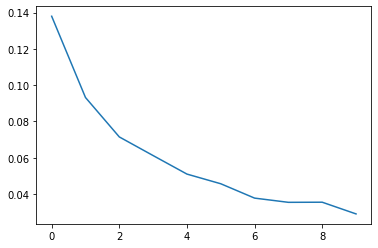

In [251]:
plt.plot(epoch_losses)

Expected 0.19 - 0.18

#### Hard training

In [320]:
batch_size=256

scaler = GradScaler()

optimizer_model = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()),
                             lr=0.001, weight_decay=0.001)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_model,
                                                   max_lr=0.001,
                                                   anneal_strategy='linear',
                                                   epochs=20,
                                                   steps_per_epoch=int(num_training_samples/batch_size),
                                                   three_phase=True)

In [321]:
for epoch in range(20):
    # The dataset is reinitialized on each epoch so that new samples are generated on evry epoch
    dataset = EmbeddingDataset(IMAGE_DIR, pd.concat([train, extra]).reset_index(drop=True), num_training_samples,
                               transform=img_transform, easy_mode=False)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        img1, img2, y =  sample
        optimizer_model.zero_grad() 
        with autocast():
            op1 = model_conv(img1.to(device))
            op2 = model_conv(img2.to(device))
            loss = cosine_loss(op1, op2, y.to(device))
            # loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * img1.size(0)
        pbar.set_description('Epoch %d - Loss : %f - Learning Rate : %f' % (epoch+1, loss.item(), lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - Loss %f' % (epoch+1, epoch_loss))

Epoch 1 - Loss : 0.197880 - Learning Rate : 0.000202: 100%|███████████████████████████████████████████████████████████████| 16/16 [07:14<00:00, 27.18s/it]


Epoch 1 - Loss 0.214728


Epoch 2 - Loss : 0.177340 - Learning Rate : 0.000363: 100%|███████████████████████████████████████████████████████████████| 16/16 [06:59<00:00, 26.23s/it]


Epoch 2 - Loss 0.185545


Epoch 3 - Loss : 0.171030 - Learning Rate : 0.000525: 100%|███████████████████████████████████████████████████████████████| 16/16 [06:54<00:00, 25.90s/it]


Epoch 3 - Loss 0.172828


Epoch 4 - Loss : 0.163279 - Learning Rate : 0.000687: 100%|███████████████████████████████████████████████████████████████| 16/16 [06:48<00:00, 25.53s/it]


Epoch 4 - Loss 0.167517


Epoch 5 - Loss : 0.155634 - Learning Rate : 0.000848: 100%|███████████████████████████████████████████████████████████████| 16/16 [07:04<00:00, 26.52s/it]


Epoch 5 - Loss 0.158635


Epoch 6 - Loss : 0.157898 - Learning Rate : 0.000990: 100%|███████████████████████████████████████████████████████████████| 16/16 [06:58<00:00, 26.14s/it]


Epoch 6 - Loss 0.153417


Epoch 7 - Loss : 0.142581 - Learning Rate : 0.000828: 100%|███████████████████████████████████████████████████████████████| 16/16 [07:02<00:00, 26.42s/it]


Epoch 7 - Loss 0.148330


Epoch 8 - Loss : 0.152484 - Learning Rate : 0.000667: 100%|███████████████████████████████████████████████████████████████| 16/16 [07:23<00:00, 27.75s/it]


Epoch 8 - Loss 0.147837


Epoch 9 - Loss : 0.154404 - Learning Rate : 0.000505: 100%|███████████████████████████████████████████████████████████████| 16/16 [07:12<00:00, 27.02s/it]


Epoch 9 - Loss 0.142565


Epoch 10 - Loss : 0.143230 - Learning Rate : 0.000343: 100%|██████████████████████████████████████████████████████████████| 16/16 [06:59<00:00, 26.23s/it]


Epoch 10 - Loss 0.142564


Epoch 11 - Loss : 0.133959 - Learning Rate : 0.000181: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:36<00:00, 28.56s/it]


Epoch 11 - Loss 0.140437


Epoch 12 - Loss : 0.133879 - Learning Rate : 0.000039: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:32<00:00, 28.27s/it]


Epoch 12 - Loss 0.141398


Epoch 13 - Loss : 0.136676 - Learning Rate : 0.000034: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:48<00:00, 29.30s/it]


Epoch 13 - Loss 0.139853


Epoch 14 - Loss : 0.159993 - Learning Rate : 0.000029: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:41<00:00, 28.85s/it]


Epoch 14 - Loss 0.142699


Epoch 15 - Loss : 0.137948 - Learning Rate : 0.000024: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:38<00:00, 28.63s/it]


Epoch 15 - Loss 0.142159


Epoch 16 - Loss : 0.134495 - Learning Rate : 0.000020: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:37<00:00, 28.58s/it]


Epoch 16 - Loss 0.138696


Epoch 17 - Loss : 0.137628 - Learning Rate : 0.000015: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:47<00:00, 29.23s/it]


Epoch 17 - Loss 0.137774


Epoch 18 - Loss : 0.133256 - Learning Rate : 0.000010: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:37<00:00, 28.58s/it]


Epoch 18 - Loss 0.133230


Epoch 19 - Loss : 0.136208 - Learning Rate : 0.000005: 100%|██████████████████████████████████████████████████████████████| 16/16 [07:57<00:00, 29.84s/it]


Epoch 19 - Loss 0.137976


Epoch 20 - Loss : 0.136528 - Learning Rate : -0.000000: 100%|█████████████████████████████████████████████████████████████| 16/16 [07:57<00:00, 29.87s/it]

Epoch 20 - Loss 0.138401


In [284]:
np.mean(epoch_losses)

0.09812385422701482

Expected 0.17 - 0.16

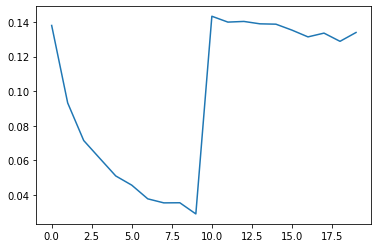

In [285]:
plt.plot(epoch_losses)

#### Generate Predictions for Submission

In [286]:
model_conv.eval();

In [322]:
cosine_similarity = nn.CosineSimilarity(dim=-1)

In [323]:
all_train_data = pd.concat([train, extra]).reset_index(drop=True)

all_train_data = all_train_data.sort_values('turtle_id')

In [324]:
indexing_dataset = TurtleDataSet(IMAGE_DIR, all_train_data, turtle_ids, transform=img_transform, include_orientation=False)

In [325]:
data_loader = torch.utils.data.DataLoader(indexing_dataset, batch_size=512, shuffle=False, num_workers=1)

In [326]:
ids = []
emb_index = []
with torch.no_grad():
    for sample in tqdm.tqdm(data_loader):
        emb = model_conv(sample['img'].to(device))
        emb.to('cpu')
        emb_index.append(emb)
        ids.append(sample['id'])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [14:00<00:00, 32.33s/it]


In [327]:
ids = torch.cat(ids)

ids = ids.numpy()

In [328]:
emb_index = torch.cat(emb_index)

In [329]:
emb_index.shape

torch.Size([12803, 64])

In [330]:
test['turtle_id'] = ''

In [331]:
test_dataset = TurtleDataSet(IMAGE_DIR, test, turtle_ids, transform=img_transform, include_orientation=False)

In [332]:
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=1)

# data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

test_image_ids = []
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
with torch.no_grad():
    for sample in pbar:
        test_image_ids.extend(sample['image_id'])
        test_emb = model_conv(sample['img'].to(device))
        # break


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.70s/it]


In [333]:
test_emb.shape[0]

490

In [334]:

preds = []
for idx in range(test_emb.shape[0]):
    pred = cosine_similarity(emb_index, test_emb[idx]).topk(k=5).indices.cpu().numpy()
    pred = list(map(lambda x: ids[x], pred))
    preds.append(pred)

In [335]:
preds = np.array(preds)

In [336]:
preds.shape

(490, 5)

In [339]:
preds = mapper(preds)

In [340]:
(preds=='new_turtle').sum(axis=0)

array([430, 420, 427, 427, 421])

In [341]:
len(test_image_ids)

490

In [342]:
predictions_df = pd.DataFrame({'image_id': test_image_ids,
                               'prediction1': preds[:, 0],
                               'prediction2': preds[:, 1],
                               'prediction3': preds[:, 2],
                               'prediction4': preds[:, 3],
                               'prediction5': preds[:, 4]})

In [345]:
(predictions_df=='new_turtle').sum()

image_id         0
prediction1    430
prediction2     56
prediction3     17
prediction4      5
prediction5      9
dtype: int64

In [346]:
predictions_df.to_csv(os.path.join('predictions', dt.datetime.now().strftime("%Y-%m-%d-%H-%M.csv")),
                      index=False)

In [275]:
os.listdir('predictions/')[-1]

'2022-03-13-12-19.csv'

In [277]:
class_predictions_df = pd.read_csv(os.path.join('predictions', os.listdir('predictions/')[-1]))

In [344]:
for ix, predictions in predictions_df.iterrows():
    if sum(predictions=='new_turtle')>1:
        replace_pred_idx = predictions.index[predictions=='new_turtle'][1:].tolist()
        predictions_df.loc[ix, replace_pred_idx] = class_predictions_df.loc[ix, replace_pred_idx]

In [178]:
0

prediction4    t_id_VP2NW7aV
Name: 0, dtype: object

### Triplet Loss

In [389]:
triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity(), margin=0.01)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda', index=0)

In [383]:
dataset = TripletDataset(IMAGE_DIR, train, 32768, transform=img_transform, easy_mode=True)

In [390]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [385]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [39]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6144MB, multi_processor_count=30)

In [21]:
scaler = GradScaler()

In [22]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [386]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [391]:
pbar = tqdm.tqdm(data_loader)
# with torch.set_grad_enabled(True):
for triplet in pbar:
    optimizer_model.zero_grad() 
    with autocast():
        anc_embed = model_conv(triplet['anc_img'].to(device))
        pos_embed = model_conv(triplet['pos_img'].to(device))
        neg_embed = model_conv(triplet['neg_img'].to(device))
        loss = triplet_loss(anc_embed, pos_embed, pos_embed)
    scaler.scale(loss).backward()
    scaler.step(optimizer_model)
    scaler.update()
    pbar.set_description('Loss : %f' % loss.item())


Loss : 0.010000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [36:59<00:00,  1.85it/s]


In [ ]:
reserved_mem = torch.cuda.memory_reserved(0)
allocated_mem = torch.cuda.memory_allocated(0)

In [ ]:
from google.colab import files

predictions_from_scratch.to_csv('submission.csv')
files.download('submission.csv')

array([[ 29,  32,  21,   1,  43],
       [ 54,  22,   3,  83,  14],
       [ 15,   3,  63,  54,  65],
       [ 71,  52,  84,  42,  27],
       [ 13,  31,   3,  38,  25],
       [ 59,  49,  33,  43,  90],
       [  2,  30,  43,  76,   7],
       [ 31, 100,  46,  16,  93]])

In [95]:
mapper(out.topk(5, dim=1).indices.cpu().numpy())

array([['t_id_15bo4NKD', 't_id_Kc1tXDbJ', 't_id_DPYQnZyv',
        't_id_qZ0iZYsC', 't_id_8b8sprYe'],
       ['t_id_uJXT7dGu', 't_id_ROFhVsy2', 't_id_YjXYTCGC',
        't_id_GOIvCduN', 't_id_NW7wn8TC'],
       ['t_id_JI6ba2Yx', 't_id_YjXYTCGC', 't_id_D0gA44av',
        't_id_uJXT7dGu', 't_id_MwnEYfqe'],
       ['t_id_fxTQ5vHC', 't_id_72SiiZCp', 't_id_pCO59rOk',
        't_id_bYageLYA', 't_id_mpuNp8mf'],
       ['t_id_Ts5LyVQz', 't_id_Kf73l69A', 't_id_YjXYTCGC',
        't_id_tjWepji1', 't_id_AOWArhGb'],
       ['t_id_WDCMGvI4', 't_id_B7LaSiac', 't_id_2Yn71r7R',
        't_id_8b8sprYe', 't_id_2E8o5Jtl'],
       ['t_id_3b65X5Lw', 't_id_QqeoI5F3', 't_id_8b8sprYe',
        't_id_VFb44eFm', 't_id_utw0thCe'],
       ['t_id_Kf73l69A', 'new_turtle', 't_id_smNwfXAT', 't_id_ifWwxWF4',
        't_id_Lhp87PBX']], dtype='<U13')

In [84]:
sample_submission = read_csv_from_web('sample_submission.csv')

In [89]:
sample_submission.head()

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
1,ID_57QZ4S9N,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
2,ID_OCGGJS5X,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
3,ID_R2993S3S,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
4,ID_2E011NB0,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor


In [110]:
sample['img'].shape

torch.Size([8, 3, 128, 128])

In [111]:
sample['id']

tensor([26,  8, 76, 60, 66, 66, 55, 34])

In [125]:
mapk(sample['id'], out.topk(5, dim=1).indices)

0.14583333333333331

In [ ]:
mapk(out,)

In [ ]:
predictions = predictions_from_scratch[[
    "prediction1", "prediction2", "prediction3", "prediction4", "prediction5"
]]
y_predict = predictions.values.tolist()

# We don't actually know the true labels for the test set, so for the purposes
# of demonstration we just assume that all of the images in the test set are of
# a single turtle:
assumed_y = ["t_id_d6aYXtor"] * len(y_predict)

mapk_result = mapk(assumed_y, y_predict, k=5)
print("With made up test set labels, our mapk with k=5 is", mapk_result)

In [33]:
import tqdm

from torch.cuda.amp import GradScaler, autocast

In [67]:
class TurtleNet(nn.Module):
    def __init__(self, num_classes, num_orientations, embedding_size):
        super(TurtleNet, self).__init__()
        
        basenet = torchvision.models.alexnet(pretrained=True)
        
        self.features = basenet.features
        # Freeze the conv weights of the pretrained model
        for param in self.features.parameters():
            param.requires_grad = False
        self.adpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.dense_layers0 = basenet.classifier
        self.dense_layers0[6] = nn.Linear(in_features=4096, out_features=128, bias=True)
        
        # self.dense_layers1 = nn.Sequential(nn.ReLU(), nn.Linear(in_features=1024, out_features=256, bias=True), nn.ReLU())
        # self.dense_layers2 = nn.Sequential(nn.Linear(in_features=512, out_features=256, bias=True), nn.ReLU())
        
        self.embedding_head = nn.Sequential(nn.Linear(in_features=128, out_features=embedding_size, bias=True), nn.ReLU())
        self.classification_head = nn.Sequential(nn.Linear(in_features=128, out_features=num_classes, bias=True), nn.ReLU())
        self.orientation_head = nn.Sequential(nn.Linear(in_features=128, out_features=num_orientations, bias=True), nn.ReLU())

    def forward(self, x):
        x = self.features(x)
        x = self.adpool(x)
        x = self.dense_layers0(x)
        x = self.dense_layers1(x)
        
        y_aux = self.orientation_head(x)
        y_main = self.classification_head(x)
        y_emb = self.embedding_head(x)
        
        
        
        return y_main, y_aux, y_embed

In [68]:
model = TurtleNet(num_classes=len(turtle_ids)+1, # +1 for the new turtle class
                  num_orientations=3, 
                  embedding_size=64)

In [57]:
optimizer = optim.SGD(
            params=filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [37]:
img_transform = transforms.Compose([
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [38]:
dataset = TurtleDataSet(IMAGE_DIR, train_df, turtle_ids, transform=img_transform, include_orientation=True)

In [39]:
cross_entropy = nn.CrossEntropyLoss()

In [40]:
model.to(device)
model.train()

TurtleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers0): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=

In [69]:
torch.cuda.empty_cache()

In [42]:
scaler = GradScaler()

In [43]:
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                 base_lr=0.00001, 
                                                 max_lr=0.001, 
                                                 step_size_up=21, 
                                                 step_size_down=42)

In [44]:
top_k_precisions = []
epoch_losses = []

In [50]:
sample['id']

tensor([ 73,  15,   8,  38,  48,  81,  72,  47,  75,  61,  56, 100,  65,  39,
          4,  81])

In [51]:
sample['orientation']

tensor([0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1])

In [71]:
model.to('cpu')
model.train()

TurtleNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (dense_layers0): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tru

In [72]:
model(sample['img'])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (24576x6 and 9216x4096)

In [45]:
for epoch in range(25):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        optimizer.zero_grad() 
        with autocast():
            op_main, op_aux, op_embed = model(sample['img'].to(device))
            loss1 = cross_entropy(op, sample['id'].to(device))
            loss2 = cross_entropy(op, sample['orientation'].to(device))
            loss = loss1+0.4*loss2
            
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss1.item() * sample['img'].size(0)
        top_k_precision = mapk(sample['id'], op_main.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pbar.set_description('Epoch %d - MAP@k : %f - Learning Rate : %f' % (epoch+1, top_k_precision, lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - MAP@k : %f - Loss %f' % (epoch+1, np.mean(top_k_precisions[-21:]), epoch_loss))

  0%|                                                                                                                                                                                      | 0/164 [00:00<?, ?it/s]/home/xion/.conda/envs/torchenv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                                                                                                                      | 0/164 [00:02<?, ?it/s]

 ** On entry to GEMM_EX  parameter number 12 had an illegal value


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasGemmEx( handle, opa, opb, m, n, k, &falpha, a, CUDA_R_16F, lda, b, CUDA_R_16F, ldb, &fbeta, c, CUDA_R_16F, ldc, CUDA_R_32F, CUBLAS_GEMM_DFALT_TENSOR_OP)`

In [42]:
torch.cuda.empty_cache()

### Custom Model
Trained from scratch

In [75]:
class TurtleNet(nn.Module):
    def __init__(self):
        super(TurtleNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Flatten()
        )
        
        self.feature_classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=32768, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=100, bias=True)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.feature_classifier(x)
        return x 

In [76]:
model_conv = TurtleNet()

In [77]:
img_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [54]:
# Clear out anymemory if possible
torch.cuda.empty_cache()

In [382]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [81]:
scaler = GradScaler()

In [84]:
dataset = TurtleDataSet(IMAGE_DIR, train, transform=img_transform)

In [82]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [85]:

# with torch.set_grad_enabled(True):
for epoch in range(10):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    for sample in pbar:
        # break
        optimizer_model.zero_grad() 
        with autocast():
            op = model_conv(sample['img'].to(device))
            loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        pbar.set_description('Epoch %d - Loss : %f' % (epoch+1, loss.item()))


Epoch 10 - Loss : 4.625000: 100%|███████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.51it/s]
